#### The goal of this notebook is to show a user several basic PySpark commands and to calculate ...

In [75]:
%load_ext autoreload
%autoreload

#%autoreload
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
display(HTML("""<style>div.output_area{max-height:10000px;overflow:scroll;}</style>"""))

from timeUtils import clock, elapsed

import os
import findspark
from pyspark import SparkContext
from operator import add
 
import random
from pandas import DataFrame, Series

import pandas as pd
pd.set_option("display.max_rows",1000)
pd.set_option('precision', 3)

import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

import warnings
warnings.filterwarnings('ignore')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Check Python

In [2]:
import sys
sys.version

'3.7.3 (default, Mar 27 2019, 16:54:48) \n[Clang 4.0.1 (tags/RELEASE_401/final)]'

# Setup Java

In [3]:
javahome=os.environ.get("JAVA_HOME")
print("JAVA_HOME -->",javahome)
## This should point to something that has 'whatever.jdk1.8.whatever' in the path. If not, nothing will work.

JAVA_HOME --> /Library/Java/JavaVirtualMachines/jdk1.8.0_152.jdk/Contents/Home


# Setup Spark

In [4]:
def setupSpark(debug=False):
    import os
    try:
        javahome=os.environ.get("JAVA_HOME")
        print("Java home is {0}".format(javahome))
    except:
        raise ValueError("There is not JAVA_HOME variable")
        
    try:
        sparkhome=os.environ.get("SPARK_HOME")
        print("Spark home is {0}".format(sparkhome))
    except:
        raise ValueError("There is not SPARK_HOME variable")
    
    try:
        import findspark
        findspark.init(sparkhome)
    except:
        raise ValueError("Could import findspark")
        
    try:
        import pyspark    
    except:
        raise ValueError("Could not import pyspark")
    
    conf = (pyspark.SparkConf()
        .setAppName('My Spark Application')
#        .setMaster('yarn')
        .set('spark.driver.memory', '120g')
        .set('spark.shuffle.service.enabled', True)
        .set('spark.dynamicAllocation.enabled', True)
#        .set('spark.executor.heartbeatInterval', '3600s')
#        .set('spark.executor.memory', '5g')
#        .set('spark.yarn.executor.memoryOverhead', '4000m')
        .set('spark.dynamicAllocation.maxExecutors', 250)
#        .set('spark.dynamicAllocation.minExecutors', 10)
        .set('spark.kryoserializer.buffer.max', '2047m')
        .set('spark.speculation', True)
        .set('spark.sql.execution.arrow.enabled', False)
#        .set('spark.jars', hivejar)
        .set('spark.port.maxRetries', 100)
        .set('spark.driver.maxResultSize', '20g')
        .set('spark.sql.broadcastTimeout', 600))
            
# VT Stuff        
#        .set("fs.adl.oauth2.access.token.provider.type","ClientCredential")
#        .set("fs.adl.oauth2.client.id","4e7f6eec-d974-4d85-9997-1288d01bf6c5")
#        .set("fs.adl.oauth2.credential","dJ8W3bZ9QR9-alR:TgTX-H.v2hDFVwIS")
#        .set("fs.adl.oauth2.refresh.url","https://login.microsoftonline.com/8a7197be-6a57-442c-b24c-ba9cf03dab93/oauth2/token"))
    
    sc = pyspark.SparkContext(conf = conf)
    sc.setLogLevel('ERROR')
    
    return sc


#from pyspark import SparkContext

In [5]:
def setupHive(sc):
    from pyspark.sql import HiveContext
    hc = HiveContext(sc)
    return hc
    
def setupSQL(sc):
    from pyspark.sql import SQLContext
    sqlc = SQLContext(sc)
    return sqlc

In [6]:
sc = setupSpark(debug=True)

Java home is /Library/Java/JavaVirtualMachines/jdk1.8.0_152.jdk/Contents/Home
Spark home is /Users/tgadfort/spark-2.4.4-bin-hadoop2.7


In [7]:
hc   = setupHive(sc)
sqlc = setupSQL(sc)

# Hello World For Spark

In [8]:
data = sc.parallelize(list("Hello World"))
counts = data.map(lambda x: (x, 1)).reduceByKey(add).sortBy(lambda x: x[1], ascending=False).collect()
for (word, count) in counts:
    print("{}: {}".format(word, count))
sc.stop()

l: 3
o: 2
H: 1
W: 1
e: 1
d: 1
 : 1
r: 1


# Odd Number Generator

### For reasons I don't fully understand we must recreate sparkContext

In [10]:
sc = setupSpark(debug=True)
hc   = setupHive(sc)
sqlc = setupSQL(sc)

Java home is /Library/Java/JavaVirtualMachines/jdk1.8.0_152.jdk/Contents/Home
Spark home is /Users/tgadfort/spark-2.4.4-bin-hadoop2.7


In [11]:
start, cmt = clock("Testing Odd Number Generator")
big_list = range(10000)
rdd = sc.parallelize(big_list, 2)
odds = rdd.filter(lambda x: x % 2 != 0)
elapsed(start, cmt)

odds.take(5)

Current Time is Wed Feb 19, 2020 12:42:03 for Testing Odd Number Generator
Current Time is Wed Feb 19, 2020 12:42:03 for Done with Testing Odd Number Generator
Process [Done with Testing Odd Number Generator] took 3.0 millseconds.


[1, 3, 5, 7, 9]

# Pi Estimation

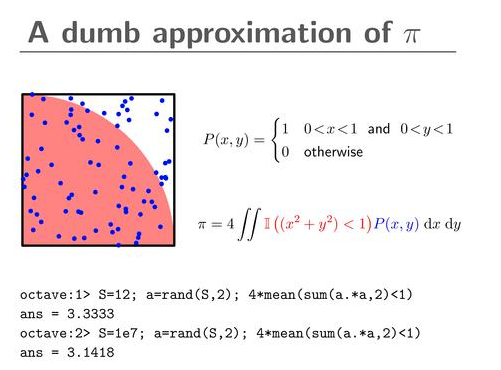

In [14]:
from IPython.core.display import Image, display
display(Image('pi.png', unconfined=True))

#### Define the perimeter of a circle of radius 1

In [22]:
def inside(p):
    x, y = random.random(), random.random()
    return x*x + y*y < 1

In [23]:
def computePiWithPython(N):
    start, cmt = clock("Testing Python with {0} events".format(N))
    pcount = sum(map(inside, range(0, N)))
    print("Pi is roughly %f" % (4.0 * pcount / N))
    runtime = elapsed(start, cmt, returnTime=True)
    return runtime

def computePiWithSpark(N):
    start, cmt = clock("Testing PySpark with {0} events".format(N))
    count = sc.parallelize(range(0, N)).filter(inside).count()
    print("Pi is roughly %f" % (4.0 * count / N))
    runtime = elapsed(start, cmt, returnTime=True)
    return runtime

#### Set up timing data

In [104]:
runtimes = {}
from numpy import linspace
exponents = linspace(3, 8, 11)
Ns = [int(10**exponent) for exponent in exponents]
runtimes = {N: {} for N in Ns}

### Run with Python
#### You will see only one process running

In [105]:
for N in Ns:
    rt = computePiWithPython(N)
    runtimes[N]["Python"] = rt

Current Time is Wed Feb 19, 2020 13:26:47 for Testing Python with 1000 events
Pi is roughly 3.180000
Current Time is Wed Feb 19, 2020 13:26:47 for Done with Testing Python with 1000 events
Process [Done with Testing Python with 1000 events] took 506 microseconds.
Current Time is Wed Feb 19, 2020 13:26:47 for Testing Python with 3162 events
Pi is roughly 3.208096
Current Time is Wed Feb 19, 2020 13:26:47 for Done with Testing Python with 3162 events
Process [Done with Testing Python with 3162 events] took 1.0 millseconds.
Current Time is Wed Feb 19, 2020 13:26:47 for Testing Python with 10000 events
Pi is roughly 3.109200
Current Time is Wed Feb 19, 2020 13:26:47 for Done with Testing Python with 10000 events
Process [Done with Testing Python with 10000 events] took 4.0 millseconds.
Current Time is Wed Feb 19, 2020 13:26:47 for Testing Python with 31622 events
Pi is roughly 3.118968
Current Time is Wed Feb 19, 2020 13:26:47 for Done with Testing Python with 31622 events
Process [Done wi

### Run with Spark
#### You will see lots of processes running

In [106]:
for N in Ns:
    rt = computePiWithSpark(N)
    runtimes[N]["Spark"] = rt

Current Time is Wed Feb 19, 2020 13:27:31 for Testing PySpark with 1000 events
Pi is roughly 3.036000
Current Time is Wed Feb 19, 2020 13:27:31 for Done with Testing PySpark with 1000 events
Process [Done with Testing PySpark with 1000 events] took 77.0 millseconds.
Current Time is Wed Feb 19, 2020 13:27:31 for Testing PySpark with 3162 events
Pi is roughly 3.167615
Current Time is Wed Feb 19, 2020 13:27:31 for Done with Testing PySpark with 3162 events
Process [Done with Testing PySpark with 3162 events] took 69.0 millseconds.
Current Time is Wed Feb 19, 2020 13:27:31 for Testing PySpark with 10000 events
Pi is roughly 3.145600
Current Time is Wed Feb 19, 2020 13:27:31 for Done with Testing PySpark with 10000 events
Process [Done with Testing PySpark with 10000 events] took 69.0 millseconds.
Current Time is Wed Feb 19, 2020 13:27:31 for Testing PySpark with 31622 events
Pi is roughly 3.139586
Current Time is Wed Feb 19, 2020 13:27:31 for Done with Testing PySpark with 31622 events
Pro

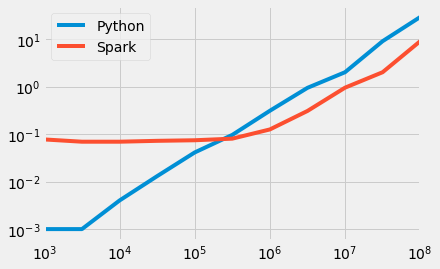

In [108]:
DataFrame(runtimes).T.plot(logx=True, logy=True)

# DataFrame Example

In [109]:
from ioUtils import getFile
moviedata = getFile("/Users/tgadfort/Documents/code/network_lunch_and_learn/data.p")
moviedata.head()

,Title,Actor,Year,Award
3,Valdemar Sejr,Peter Malberg,1910,NaN
4,Valdemar Sejr,Ellen Gottschalch,1910,NaN
7,Ekspeditricen,Clara Pontoppidan,1911,NaN
8,Ekspeditricen,Thorkild Roose,1911,NaN
11,Par habitude,Maurice Chevalier,1911,NaN


In [110]:
# Enable Arrow-based columnar data transfers
#spark.conf.set("spark.sql.execution.arrow.enabled", "true")

# Create a Spark DataFrame from a pandas DataFrame
start, cmt = clock("Creating IMDB Spark DataFrame")
spdf = hc.createDataFrame(moviedata)
spdf.cache()
elapsed(start, cmt)

Current Time is Wed Feb 19, 2020 13:28:18 for Creating IMDB Spark DataFrame
Current Time is Wed Feb 19, 2020 13:28:22 for Done with Creating IMDB Spark DataFrame
Process [Done with Creating IMDB Spark DataFrame] took 4 seconds.


In [111]:
from pyspark.sql.functions import countDistinct, col, max, min
print("Total Rows = {0}".format(spdf.count()))
print("Total Cols = {0}".format(len(spdf.columns)))
spdf.agg(countDistinct("Actor")).show()
spdf.agg(min(col("Year"))).show()
spdf.agg(max(col("Year"))).show()

Total Rows = 132236
Total Cols = 4
+---------------------+
|count(DISTINCT Actor)|
+---------------------+
|                11123|
+---------------------+

+---------+
|min(Year)|
+---------+
|     1910|
+---------+

+---------+
|max(Year)|
+---------+
|     2027|
+---------+



### Count Number of Rows with Column Value (i.e., how many movies were made each year) 

In [112]:
spdf.groupBy('Year').count().show(3)
## Somewhat equivalent Pandas command
moviedata.groupby('Year').size().head(3)

+----+-----+
|Year|count|
+----+-----+
|1950| 1448|
|1919|  163|
|1936| 1442|
+----+-----+
only showing top 3 rows



Year
1910    3
1911    5
1912    1
dtype: int64

#### Try Actor/Actress With The Most Films

In [113]:
result = spdf.groupBy('Actor').count() \
             .filter("`count` >= 10") \
             .sort(col("count").desc())

#### Spark won't compute anything until it needs to show it

In [114]:
result.show(5)

+----------------+-----+
|           Actor|count|
+----------------+-----+
|    Eric Roberts|  144|
|Gérard Depardieu|  129|
|      John Wayne|  113|
|       Jack Holt|  113|
|  Michel Piccoli|  111|
+----------------+-----+
only showing top 5 rows



#### Try Caching Result And See Speed Increase

In [115]:
result = result.cache()

In [116]:
result.show(5)

+----------------+-----+
|           Actor|count|
+----------------+-----+
|    Eric Roberts|  144|
|Gérard Depardieu|  129|
|       Jack Holt|  113|
|      John Wayne|  113|
|  Michel Piccoli|  111|
+----------------+-----+
only showing top 5 rows



# Spark SQL (Using KDD '99 Data)

#### Load 2MB GZIP File With KDD Data

In [117]:
start, cmt = clock("Creating Spark DataFrame From GZIP -> RDD -> Rows -> Spark")

Current Time is Wed Feb 19, 2020 13:28:47 for Creating Spark DataFrame From GZIP -> RDD -> Rows -> Spark


In [118]:
data_file = "kddcup.data_10_percent.gz"
raw_rdd = sc.textFile(data_file).cache()
raw_rdd.take(1)

['0,tcp,http,SF,181,5450,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,8,8,0.00,0.00,0.00,0.00,1.00,0.00,0.00,9,9,1.00,0.00,0.11,0.00,0.00,0.00,0.00,0.00,normal.']

#### Creating a Spark DataFrame Directly From The RDD

In [119]:
csv_rdd = raw_rdd.map(lambda row: row.split(","))
csv_rdd.take(1)

[['0',
  'tcp',
  'http',
  'SF',
  '181',
  '5450',
  '0',
  '0',
  '0',
  '0',
  '0',
  '1',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '8',
  '8',
  '0.00',
  '0.00',
  '0.00',
  '0.00',
  '1.00',
  '0.00',
  '0.00',
  '9',
  '9',
  '1.00',
  '0.00',
  '0.11',
  '0.00',
  '0.00',
  '0.00',
  '0.00',
  '0.00',
  'normal.']]

#### Create List of Spark Rows From Split CSV Data

In [120]:
from pyspark.sql import Row

#pddf.columns = ["duration", "protocol_type", "service", "flag", "src_bytes", "dst_bytes", "land", "wrong_fragment", "urgent", "hot", "num_failed_logins", "logged_in", "num_compromised", "root_shell", "su_attempted", "num_root", "num_file_creations", "num_shells", "num_access_files", "num_outbound_cmds", "is_host_login", "is_guest_login", "count", "srv_count", "serror_rate", "srv_serror_rate", "rerror_rate", "srv_rerror_rate", "same_srv_rate", "diff_srv_rate", "srv_diff_host_rate", "dst_host_count", "dst_host_srv_count", "dst_host_same_srv_rate", "dst_host_diff_srv_rate", "dst_host_same_src_port_rate", "dst_host_srv_diff_host_rate", "dst_host_serror_rate", "dst_host_srv_serror_rate", "dst_host_rerror_rate", "dst_host_srv_rerror_rate", "label"]

parsed_rdd = csv_rdd.map(lambda r: Row(
    duration=int(r[0]), 
    protocol_type=r[1],
    service=r[2],
    flag=r[3],
    src_bytes=int(r[4]),
    dst_bytes=int(r[5]),
    wrong_fragment=int(r[7]),
    urgent=int(r[8]),
    hot=int(r[9]),
    num_failed_logins=int(r[10]),
    logged_in=int(r[11]),
    num_compromised=int(r[12]),
    root_shell=int(r[13]),
    su_attempted=r[14],
    num_root=int(r[15]),
    num_file_creations=int(r[16]),
    num_shells=int(r[17]),
    num_access_files=int(r[18]),
    num_outbound_cmds=int(r[19]),
    is_host_login=int(r[20]),
    is_guest_login=int(r[21]),
    count=int(r[22]),
    srv_count=int(r[23]),
    serror_rate=float(r[24]),
    srv_serror_rate=float(r[25]),
    rerror_rate=float(r[26]),
    srv_rerror_rate=float(r[27]),
    same_srv_rate=float(r[28]),
    diff_srv_rate=float(r[29]),
    srv_diff_host_rate=float(r[30]),
    dst_host_count=int(r[31]),
    dst_host_srv_count=int(r[32]),
    dst_host_same_srv_rate=float(r[33]),
    dst_host_diff_srv_rate=float(r[34]),
    dst_host_same_src_port_rate=float(r[35]),
    dst_host_srv_diff_host_rate=float(r[36]),
    dst_host_serror_rate=float(r[37]),
    dst_host_srv_serror_rate=float(r[38]),
    dst_host_rerror_rate=float(r[39]),
    dst_host_srv_rerror_rate=float(r[40]),
    label=r[-1]
    )
)
parsed_rdd.take(1)

[Row(count=8, diff_srv_rate=0.0, dst_bytes=5450, dst_host_count=9, dst_host_diff_srv_rate=0.0, dst_host_rerror_rate=0.0, dst_host_same_src_port_rate=0.11, dst_host_same_srv_rate=1.0, dst_host_serror_rate=0.0, dst_host_srv_count=9, dst_host_srv_diff_host_rate=0.0, dst_host_srv_rerror_rate=0.0, dst_host_srv_serror_rate=0.0, duration=0, flag='SF', hot=0, is_guest_login=0, is_host_login=0, label='normal.', logged_in=1, num_access_files=0, num_compromised=0, num_failed_logins=0, num_file_creations=0, num_outbound_cmds=0, num_root=0, num_shells=0, protocol_type='tcp', rerror_rate=0.0, root_shell=0, same_srv_rate=1.0, serror_rate=0.0, service='http', src_bytes=181, srv_count=8, srv_diff_host_rate=0.0, srv_rerror_rate=0.0, srv_serror_rate=0.0, su_attempted='0', urgent=0, wrong_fragment=0)]

In [121]:
spdf = sqlc.createDataFrame(parsed_rdd)
print("Total Rows = {0}".format(spdf.count()))
print("Total Cols = {0}".format(len(spdf.columns)))

Total Rows = 494021
Total Cols = 41


In [122]:
elapsed(start, cmt)

Current Time is Wed Feb 19, 2020 13:28:57 for Done with Creating Spark DataFrame From GZIP -> RDD -> Rows -> Spark
Process [Done with Creating Spark DataFrame From GZIP -> RDD -> Rows -> Spark] took 10 seconds.


#### Load GZIP Data And Convert To Python String Object

In [123]:
start, cmt = clock("Creating Spark DataFrame From GZIP -> CSV -> Pandas -> Spark")

Current Time is Wed Feb 19, 2020 13:28:57 for Creating Spark DataFrame From GZIP -> CSV -> Pandas -> Spark


In [124]:
import gzip
gbuffer    = gzip.open("kddcup.data_10_percent.gz", 'rb') ## Returns a Buffer
gbytesdata = gbuffer.read()  ## Reads the data into a `bytes` object
gstrdata   = gbytesdata.decode("utf-8")  ## Decode the 'encoded' btyes object using UTF-8. It's now a string object
print("1st 50 Characters  ==>  {0}".format(gstrdata[:50]))

1st 50 Characters  ==>  0,tcp,http,SF,181,5450,0,0,0,0,0,1,0,0,0,0,0,0,0,0


#### Create Pandas DataFrame From CSV String

In [125]:
from pandas import DataFrame
splitdata = gstrdata.split("\n")
splitdata = [x.split(",") for x in splitdata]
pddf = DataFrame(splitdata)
pddf.columns = ["duration", "protocol_type", "service", "flag", "src_bytes", "dst_bytes", "land", "wrong_fragment", "urgent", "hot", "num_failed_logins", "logged_in", "num_compromised", "root_shell", "su_attempted", "num_root", "num_file_creations", "num_shells", "num_access_files", "num_outbound_cmds", "is_host_login", "is_guest_login", "count", "srv_count", "serror_rate", "srv_serror_rate", "rerror_rate", "srv_rerror_rate", "same_srv_rate", "diff_srv_rate", "srv_diff_host_rate", "dst_host_count", "dst_host_srv_count", "dst_host_same_srv_rate", "dst_host_diff_srv_rate", "dst_host_same_src_port_rate", "dst_host_srv_diff_host_rate", "dst_host_serror_rate", "dst_host_srv_serror_rate", "dst_host_rerror_rate", "dst_host_srv_rerror_rate", "label"]
elapsed(start, cmt)

Current Time is Wed Feb 19, 2020 13:29:04 for Done with Creating Spark DataFrame From GZIP -> CSV -> Pandas -> Spark
Process [Done with Creating Spark DataFrame From GZIP -> CSV -> Pandas -> Spark] took 7 seconds.


#### Create Spark DataFrame From Pandas DataFrame

In [126]:
spdf = hc.createDataFrame(pddf)
print("Total Rows = {0}".format(spdf.count()))
print("Total Cols = {0}".format(len(spdf.columns)))

Total Rows = 494022
Total Cols = 42


In [127]:
elapsed(start, cmt)

Current Time is Wed Feb 19, 2020 13:30:37 for Done with Creating Spark DataFrame From GZIP -> CSV -> Pandas -> Spark
Process [Done with Creating Spark DataFrame From GZIP -> CSV -> Pandas -> Spark] took 1.6 minutes.


## KDD '99 Spark DataFrame SQL Access 

#### Collect results using PySpark statements

In [128]:
protocols = spdf.groupBy('protocol_type').count().orderBy('count', ascending=False)
protocols.show()

+-------------+------+
|protocol_type| count|
+-------------+------+
|         icmp|283602|
|          tcp|190065|
|          udp| 20354|
|         null|     1|
+-------------+------+



#### Collect results using SQL statements

In [129]:
spdf.registerTempTable("connections")  ## Must register the DataFrame as a Table (Temp)

#### Run previous command, but through a SQL statement

In [130]:
protocols = sqlc.sql("""SELECT protocol_type, count(*) as freq
                        FROM connections
                        GROUP BY protocol_type
                        ORDER BY 2 DESC
                        """)
protocols.show()

+-------------+------+
|protocol_type|  freq|
+-------------+------+
|         icmp|283602|
|          tcp|190065|
|          udp| 20354|
|         null|     1|
+-------------+------+



#### Another SQL example

In [131]:
attack_protocol = sqlc.sql("""
                           SELECT 
                             protocol_type, 
                             CASE label
                               WHEN 'normal.' THEN 'no attack'
                               ELSE 'attack'
                             END AS state,
                             COUNT(*) as freq
                           FROM connections
                           GROUP BY protocol_type, state
                           ORDER BY 3 DESC
                           """)
attack_protocol.show()

+-------------+---------+------+
|protocol_type|    state|  freq|
+-------------+---------+------+
|         icmp|   attack|282314|
|          tcp|   attack|113252|
|          tcp|no attack| 76813|
|          udp|no attack| 19177|
|         icmp|no attack|  1288|
|          udp|   attack|  1177|
|         null|   attack|     1|
+-------------+---------+------+



#### Yet another SQL example

In [132]:
attack_stats = sqlc.sql("""
                           SELECT 
                             protocol_type, 
                             CASE label
                               WHEN 'normal.' THEN 'no attack'
                               ELSE 'attack'
                             END AS state,
                             COUNT(*) as total_freq,
                             ROUND(AVG(src_bytes), 2) as mean_src_bytes,
                             ROUND(AVG(dst_bytes), 2) as mean_dst_bytes,
                             ROUND(AVG(duration), 2) as mean_duration,
                             SUM(num_failed_logins) as total_failed_logins,
                             SUM(num_compromised) as total_compromised,
                             SUM(num_file_creations) as total_file_creations,
                             SUM(su_attempted) as total_root_attempts,
                             SUM(num_root) as total_root_acceses
                           FROM connections
                           GROUP BY protocol_type, state
                           ORDER BY 3 DESC
                           """)
attack_stats.show()

+-------------+---------+----------+--------------+--------------+-------------+-------------------+-----------------+--------------------+-------------------+------------------+
|protocol_type|    state|total_freq|mean_src_bytes|mean_dst_bytes|mean_duration|total_failed_logins|total_compromised|total_file_creations|total_root_attempts|total_root_acceses|
+-------------+---------+----------+--------------+--------------+-------------+-------------------+-----------------+--------------------+-------------------+------------------+
|         icmp|   attack|    282314|        932.14|           0.0|          0.0|                0.0|              0.0|                 0.0|                0.0|               0.0|
|          tcp|   attack|    113252|       9880.38|        881.41|        23.19|               57.0|           2269.0|                76.0|                1.0|             152.0|
|          tcp|no attack|     76813|       1439.31|       4263.97|        11.08|               18.0|     

#### Bring everything back to Pandas

In [133]:
attack_stats_df = attack_stats.toPandas()
attack_stats_df

,protocol_type,state,total_freq,mean_src_bytes,mean_dst_bytes,mean_duration,total_failed_logins,total_compromised,total_file_creations,total_root_attempts,total_root_acceses
0,icmp,attack,282314,932.14,0.00,0.00,0.0,0.0,0.0,0.0,0.0
1,tcp,attack,113252,9880.38,881.41,23.19,57.0,2269.0,76.0,1.0,152.0
2,tcp,no attack,76813,1439.31,4263.97,11.08,18.0,2776.0,459.0,17.0,5456.0
3,udp,no attack,19177,98.01,89.89,1054.63,0.0,0.0,0.0,0.0,0.0
4,icmp,no attack,1288,91.47,0.00,0.00,0.0,0.0,0.0,0.0,0.0
5,udp,attack,1177,27.50,0.23,0.00,0.0,0.0,0.0,0.0,0.0
6,None,attack,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Running Python Code In PySpark

In [134]:
from pyspark.sql import SparkSession

spark = SparkSession \
    .builder \
    .appName("Python Spark SQL basic example") \
    .config("spark.some.config.option", "some-value") \
    .getOrCreate()

## Load a CSV with header and ';' delimiter
spdf = spark.read.load("bank.csv", format="csv", sep=";", inferSchema="true", header="true", quote="\"")
spdf.show(1)

+---+----------+-------+---------+-------+-------+-------+----+--------+---+-----+--------+--------+-----+--------+--------+---+
|age|       job|marital|education|default|balance|housing|loan| contact|day|month|duration|campaign|pdays|previous|poutcome|  y|
+---+----------+-------+---------+-------+-------+-------+----+--------+---+-----+--------+--------+-----+--------+--------+---+
| 30|unemployed|married|  primary|     no|   1787|     no|  no|cellular| 19|  oct|      79|       1|   -1|       0| unknown| no|
+---+----------+-------+---------+-------+-------+-------+----+--------+---+-----+--------+--------+-----+--------+--------+---+
only showing top 1 row



## Define Python functions and let Spark know about them via a UDF (user defined function)

In [135]:
def squareF(z):
    try:
        return z**2
    except:
        return None

def squareFconv(z):
    try:
        return float(z**2)
    except:
        return None


def square(z):
    try:
        return z**2
    except:
        return None


## Import UDF From PySpark Functions
from pyspark.sql.functions import udf
## Import Types
from pyspark.sql.types import FloatType, IntegerType


## Create 3 UDFs
square_udf_int = udf(lambda z: square(z), IntegerType())
square_udf_float = udf(lambda z: squareF(z), FloatType())
square_udf_float_conv = udf(lambda z: squareFconv(z), FloatType())

#### Show Only Certain Columns of PySpark DataFrame

In [136]:
spdf.select(["age", "education", "balance"]).show(5)

+---+---------+-------+
|age|education|balance|
+---+---------+-------+
| 30|  primary|   1787|
| 33|secondary|   4789|
| 35| tertiary|   1350|
| 30| tertiary|   1476|
| 59|secondary|      0|
+---+---------+-------+
only showing top 5 rows



##### Apply The "Square an Integer" UDF to the 'Age' column

In [137]:
dummy = spdf.withColumn('ageSquared', square_udf_int('age'))
dummy.select(["age", "education", "balance", "ageSquared"]).show(5)

+---+---------+-------+----------+
|age|education|balance|ageSquared|
+---+---------+-------+----------+
| 30|  primary|   1787|       900|
| 33|secondary|   4789|      1089|
| 35| tertiary|   1350|      1225|
| 30| tertiary|   1476|       900|
| 59|secondary|      0|      3481|
+---+---------+-------+----------+
only showing top 5 rows



##### Apply The "Square an Integer" UDF to the 'Eduction' column

In [138]:
dummy = spdf.withColumn('eductionSquared', square_udf_int('education'))
dummy.select(["age", "education", "balance", "eductionSquared"]).show(5)

+---+---------+-------+---------------+
|age|education|balance|eductionSquared|
+---+---------+-------+---------------+
| 30|  primary|   1787|           null|
| 33|secondary|   4789|           null|
| 35| tertiary|   1350|           null|
| 30| tertiary|   1476|           null|
| 59|secondary|      0|           null|
+---+---------+-------+---------------+
only showing top 5 rows



##### Apply The "Square a Float" UDF to the 'Balance' column

In [139]:
dummy = spdf.withColumn('balanceSquared', square_udf_float('balance'))
dummy.select(["age", "education", "balance", "balanceSquared"]).show(5)

+---+---------+-------+--------------+
|age|education|balance|balanceSquared|
+---+---------+-------+--------------+
| 30|  primary|   1787|          null|
| 33|secondary|   4789|          null|
| 35| tertiary|   1350|          null|
| 30| tertiary|   1476|          null|
| 59|secondary|      0|          null|
+---+---------+-------+--------------+
only showing top 5 rows



##### Apply The "Square a Float and Force Conversion to Type Float" UDF to the 'Balance' column

In [140]:
dummy = spdf.withColumn('balanceConvSquared', square_udf_float_conv('balance'))
dummy.select(["age", "education", "balance", "balanceConvSquared"]).show(5)

+---+---------+-------+------------------+
|age|education|balance|balanceConvSquared|
+---+---------+-------+------------------+
| 30|  primary|   1787|         3193369.0|
| 33|secondary|   4789|        2.293452E7|
| 35| tertiary|   1350|         1822500.0|
| 30| tertiary|   1476|         2178576.0|
| 59|secondary|      0|               0.0|
+---+---------+-------+------------------+
only showing top 5 rows



# Machine Learning (Extra Credit)

## Using MLlib For Classification

In [ ]:
from pyspark.sql import SparkSession

spark = SparkSession \
    .builder \
    .appName("Python Spark SQL basic example") \
    .config("spark.some.config.option", "some-value") \
    .getOrCreate()

## Load a CSV with header and ';' delimiter
spdf = spark.read.load("bank.csv", format="csv", sep=";", inferSchema="true", header="true", quote="\"")
cols = spdf.columns

In [ ]:
from pyspark.ml.feature import OneHotEncoderEstimator, StringIndexer, VectorAssembler
categoricalColumns = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'poutcome']
stages = []
for categoricalCol in categoricalColumns:
    stringIndexer = StringIndexer(inputCol = categoricalCol, outputCol = categoricalCol + 'Index')
    encoder = OneHotEncoderEstimator(inputCols=[stringIndexer.getOutputCol()], outputCols=[categoricalCol + "classVec"])
    stages += [stringIndexer, encoder]
label_stringIdx = StringIndexer(inputCol = 'y', outputCol = 'label')
stages += [label_stringIdx]
numericCols = ['age', 'balance', 'duration', 'campaign', 'pdays', 'previous']
assemblerInputs = [c + "classVec" for c in categoricalColumns] + numericCols
assembler = VectorAssembler(inputCols=assemblerInputs, outputCol="features")
stages += [assembler]

In [ ]:
from pyspark.ml import Pipeline
pipeline = Pipeline(stages = stages)
pipelineModel = pipeline.fit(spdf)
spdf = pipelineModel.transform(spdf)
selectedCols = ['label', 'features'] + cols
df = spdf.select(selectedCols)
df.printSchema()

In [ ]:
train, test = df.randomSplit([0.7, 0.3], seed = 2018)
print("Training Dataset Count: " + str(train.count()))
print("Test Dataset Count: " + str(test.count()))

In [ ]:
from pyspark.ml.classification import LogisticRegression
lr = LogisticRegression(featuresCol = 'features', labelCol = 'label', maxIter=10)
lrModel = lr.fit(train)


#We can obtain the coefficients by using LogisticRegressionModel’s attributes.

import matplotlib.pyplot as plt
import numpy as np
beta = np.sort(lrModel.coefficients)
plt.plot(beta)
plt.ylabel('Beta Coefficients')
plt.show()

In [ ]:
trainingSummary = lrModel.summary
print('Training set areaUnderROC: ' + str(trainingSummary.areaUnderROC))

## Using MLlib For Clustering

### Generate some random "blobs" for clustering

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.datasets.samples_generator import make_blobs
from pyspark import SparkContext
from pyspark.ml.clustering import KMeans
from pyspark.ml.feature import VectorAssembler
from pyspark.sql import SQLContext

nCenters = 25

for (n_samples, name) in [(int(1e5), "small.csv"), (int(1e6), "mid.csv"), (int(3e6), "large.csv")]:
    n_features=3
    X, y = make_blobs(n_samples=n_samples, centers=nCenters, n_features=n_features, random_state=42)
    if name == "small.csv":
        plotData = [X, y]

    # add a row index as a string
    pddf = pd.DataFrame(X, columns=['x', 'y', 'z'])
    pddf['id'] = 'row'+pddf.index.astype(str)

    #move it first (left)
    cols = list(pddf)
    cols.insert(0, cols.pop(cols.index('id')))
    pddf = pddf.ix[:, cols]
    pddf.head()

    # save the ndarray as a csv file
    print("Saving {0} data values to {1}".format(n_samples, name))
    pddf.to_csv(name, index=False)

### Plot data to see what we generated

In [ ]:
threedee = plt.figure(figsize=(12,10)).gca(projection='3d')
threedee.scatter(plotData[0][:,0], plotData[0][:,1], plotData[0][:,2], c=plotData[1])
threedee.set_xlabel('x')
threedee.set_ylabel('y')
threedee.set_zlabel('z')
plt.show()

## KMeans Clustering With PySpark

In [ ]:
csvfile = "small.csv"
plotClusters = False
start, cmt = clock("Running KMeans With PySpark")

In [ ]:
from pyspark.sql import SparkSession

spark = SparkSession \
    .builder \
    .appName("Python Spark SQL basic example") \
    .config("spark.some.config.option", "some-value") \
    .getOrCreate()

## Load a CSV with header and ';' delimiter
spdf = spark.read.load(csvfile, format="csv", sep=",", inferSchema="true", header="true") #, quote="\"")
cols = spdf.columns
FEATURES_COL = ['x', 'y', 'z']
print(spdf.dtypes)
spdf.show(3)

#### Set Format For MLlib

In [ ]:
vecAssembler = VectorAssembler(inputCols=FEATURES_COL, outputCol="features")
spdf_kmeans = vecAssembler.transform(spdf).select('id', 'features')
spdf_kmeans.show(3)

#### Run a 'cost' analysis to determine optimal number of clusters

In [ ]:
## Runs Spark KMeans
runCost = False
if runCost is True:
    cost = np.zeros(20)
    for k in range(2,20):
        kmeans = KMeans().setK(k).setSeed(1).setFeaturesCol("features")
        model = kmeans.fit(spdf_kmeans.sample(False,0.1, seed=42))
        cost[k] = model.computeCost(spdf_kmeans) # requires Spark 2.0 or later


    fig, ax = plt.subplots(1,1, figsize =(8,6))
    ax.plot(range(2,20),cost[2:20])
    ax.set_xlabel('k')
    ax.set_ylabel('cost')

#### Choose 10 clusters because that's what we actually generated

In [ ]:
k = nCenters
kmeans = KMeans().setK(k).setSeed(1).setFeaturesCol("features")
model = kmeans.fit(spdf_kmeans)
centers = model.clusterCenters()

print("Cluster Centers: ")
for center in centers:
    print(center)

#### Predict cluster for generated data

In [ ]:
transformed = model.transform(spdf_kmeans).select('id', 'prediction')
rows = transformed.collect()

spdf_pred = spark.createDataFrame(rows)
spdf_pred.show(5)

#### Join with generated data

In [ ]:
spdf_pred = spdf_pred.join(spdf, 'id')
spdf_pred.show(5)

#### Convert to Pandas and set index

In [ ]:
pddf_pred = spdf_pred.toPandas().set_index('id')
pddf_pred.head()

#### Plot everything

In [ ]:
if plotClusters:
    threedee = plt.figure(figsize=(12,10)).gca(projection='3d')
    threedee.scatter(pddf_pred.x, pddf_pred.y, pddf_pred.z, c=pddf_pred.prediction)
    threedee.set_xlabel('x')
    threedee.set_ylabel('y')
    threedee.set_zlabel('z')
    plt.show()

In [ ]:
elapsed(start, cmt)

In [ ]:
## Just sleep to cool off
from time import sleep
sleep(2)

## KMeans Clustering With Sklean + Pandas (For Comparison)

In [ ]:
#csvfile = "small.csv"
start, cmt = clock("Running KMeans With Sklean + Pandas")

In [ ]:
from pandas import read_csv
clusterData = read_csv(csvfile)
clusterData.index = clusterData['id']
clusterData.drop(['id'], axis=1, inplace=True)
clusterData.head()

#### Create clusters and predict

In [ ]:
from sklearn.cluster import KMeans as SklearnKMeans
kmeans = SklearnKMeans(n_clusters=nCenters)
kmeans.fit(clusterData)
y_kmeans = kmeans.predict(clusterData)

#### Join everything together

In [ ]:
from pandas import Series
pddf_pred_sk = DataFrame(y_kmeans, index=clusterData.index)
pddf_pred_sk.columns = ['prediction']
pddf_pred_sk = pddf_pred_sk.join(clusterData) ## This works because we have identical indices
pddf_pred_sk.head()

#### Same plot, but doing it all with Pandas + Sklean

In [ ]:
if plotClusters:
    threedee = plt.figure(figsize=(12,10)).gca(projection='3d')
    threedee.scatter(pddf_pred_sk.x, pddf_pred_sk.y, pddf_pred_sk.z, c=pddf_pred_sk.prediction)
    threedee.set_xlabel('x')
    threedee.set_ylabel('y')
    threedee.set_zlabel('z')
    plt.show()

In [ ]:
elapsed(start, cmt)